In [24]:
import gym
import os
from stable_baselines.results_plotter import load_results
from seagul.plot import smooth_bounded_curve
from seagul.mesh import create_mesh
import matplotlib.pyplot as plt
import numpy as np
import torch
import pybullet_envs
from stable_baselines import TD3 as ALGO
import time
import seagul.envs
import pybullet as p
import json
import pybulletgym
from seagul.envs.wrappers import PyBulletPhysicsWrapper

#env_name = "Walker2d-v2"
env_name = "Walker2DBulletEnv-v0"
#env_name = "pbmj_walker2dfc-v0"
#env_name = "Walker2DMuJoCoEnv-v0"

def do_rollout_stable(init_point=None, render=False, video=False):
    env = gym.make(env_name, render=render)
    #env = PyBulletPhysicsWrapper(gym.make(env_name, render=render), **config)
    model.observation_space = env.observation_space
    obs=env.reset()
    #td3_model = TD3.load(script_path + "../rl-baselines-zoo/baseline_log2/td3/su_acrobot_cdc-v0_2/su_acrobot_cdc-v0.zip")

    obs = torch.as_tensor(obs, dtype=torch.float32)

    acts_list = []
    obs1_list = []
    rews_list = []
    img_list = []

    dtype = torch.float32
    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

    while not done:
        acts = model.predict(obs)[0]
        obs, rew, done, out = env.step(acts)
  
        if render:
            time.sleep(.005)
            env.unwrapped.camera_adjust()
        if video:
            img_list.append(env.render(mode='rgb_array'))
            env.unwrapped.camera_adjust()
            
        obs1_list.append(obs)
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)
    p.disconnect()

    return ep_obs1, ep_acts, ep_rews, img_list

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


<Figure size 432x288 with 0 Axes>

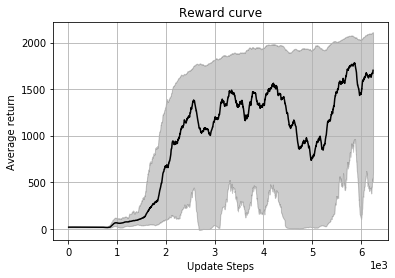

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
# %%
fig, ax = plt.subplots(1,1)

#log_dir = script_path + './walker_log'
df_list = []
model_list = []
min_length = float('inf')

trial_path = "/home/sgillen/work/contact/run_stable/data2/zoo_td3_mon/"
#trial_path = "/home/sgillen/work/contact/run_stable/data_pbp/td3/rest_35_long"
#trial_path = "/home/sgillen/work/contact/run_stable/data_pbp/td3/not_dantzig"


for entry in os.scandir(trial_path):
    if ".ipynb" in entry.path:
        continue
    if "config" in entry.path:
        config = json.load(open(entry.path))
        continue
    
    df = load_results(entry.path)


    if len(df['r']) < min_length:
        min_length = len(df['r'])

    #plt.plot(df['r'])
    plt.figure()
    df_list.append(df)
    model_list.append(ALGO.load(entry.path + "/model.zip"))

min_length = int(min_length)
rewards = np.zeros((min_length, len(df_list)))

for i, df in enumerate(df_list):
    rewards[:, i] = np.array(df['r'][:min_length])

smooth_bounded_curve(rewards[:min_length], ax=ax)
 
ax.grid()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#fig.savefig(script_path + '../figs/reward.png')
plt.figure() 

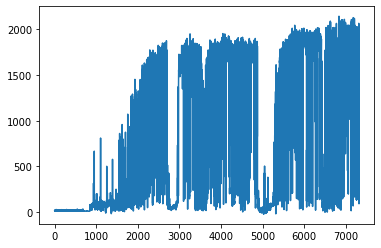

/home/sgillen/miniconda3/envs/stable/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


reward sum: 249.8097686767578


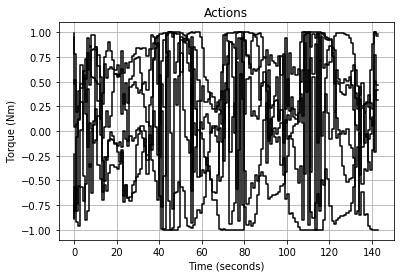

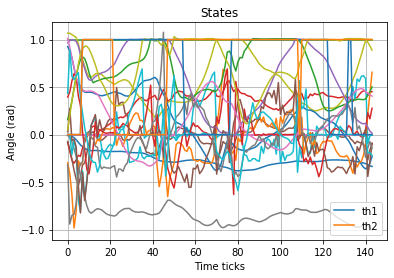

In [22]:
trial_num = 5

model = model_list[trial_num]
df = df_list[trial_num]
plt.plot(df['r']); plt.show()

obs_hist, act_hist, rew_hist, img_list = do_rollout_stable(render=True, video=False)

print(f"reward sum: {sum(rew_hist)}")

plt.step([i for i in range(act_hist.shape[0])], act_hist, 'k')
plt.title('Actions')
plt.xlabel('Time (seconds)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States')
plt.xlabel('Time ticks')
plt.ylabel('Angle (rad)')
plt.legend(['th1', 'th2'])
plt.grid()
#plt.savefig(script_path + '../figs/obs_hist.png')
plt.show()

In [4]:
folder = "/home/sgillen/work/contact/run_stable/tmp_video"
import matplotlib.cm as cm
import subprocess
import glob

def generate_video(img):
    for i in range(len(img)):
        plt.imshow(img[i], cmap=cm.Greys_r)
        plt.savefig(folder + "/file%02d.png" % i)

    os.chdir(folder)
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [31]:
import cv2

#fourcc = cv2.VideoWriter_fourcc(*'X264')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#fourcc = cv2.VideoWriter_fourcc(*'MJPG')

video_dir = "./tmp_video/"
text = "/".join(trial_path.split("/")[4:]) + "--" + "trial_" + str(trial_num)
video = cv2.VideoWriter(video_dir + "video.mp4", fourcc, 60, (img_list[0].shape[1],img_list[0].shape[0]))
assert(video.isOpened())

for frame in img_list:
    position = (5,230)
    frame = cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, .25, (0, 0, 0, 0), 1)
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
    video.write(frame)
    
video.release()

In [4]:
obs_hist, act_hist, rew_hist, img_list = do_rollout_stable(render=False, video=True)

from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(img_list, fps=60)
clip.write_gif("test.gif", fps=60)

WalkerBase::__init__


t:   2%|▏         | 20/1001 [00:00<00:05, 195.43it/s, now=None]

MoviePy - Building file test.gif with imageio.


In [30]:
mesh, weights = create_mesh(obs_hist, .1)
mesht = np.stack(mesh)

--- "more" ---
[0]:  z - self.initial_z,
[1]:  np.sin(angle_to_target),
[2]:  np.cos(angle_to_target),
[3]:  0.3 * vx,
[4]:  0.3 * vy,
[5]:  0.3 * vz,  # 0.3 is just scaling typical speed into -1..+1, no physical sense here
[6]:  r, # body roll
[7]:  p  # body pitch
--- "joint variables" ---- (joint range refers the physical range allowed by the sim, each joint is scaled so -1 is the lower joint limit, and +1 is the higher joint limit)
[8]:  thigh_joint relative angle (scaled to -1 1) (joint range -2.61 0.0) (this is the green thigh when rendered)
[9]:  thigh_joint relative velocity*.1 
[10]: leg_joint relative angle (scaled -1 1) (joint range -2.61 0.0)
[11]: leg_joint relative velocity*.1
[12]: foot_joint relative angle (scaled to -1 1) (joint range -.785 .785)
[13]: foot_joint relative velocity*.1
[14]: thigh_left_joint relative angle (scaled to -1 1) (joint range -2.61 0.0) (this is the red thigh when rendered)
[15]: thigh_left_joint relative velocity*.1 
[16]: leg_left_joint relative angle (scaled -1 1) (joint range -2.61 0.0)
[17]: leg_left_joint relative velocity*.1
[18]: foot_left_joint relative angle (scaled to -1 1) (joint range -.785 .785)
[19]: foot_left_joint relative velocity*.1
--- "foot contact" ----
[20]: robot.feet_contact[0] # right foot, green
[21]: robot.feet_contact[2] # left foot, red


IndexError: index 16 is out of bounds for axis 1 with size 16

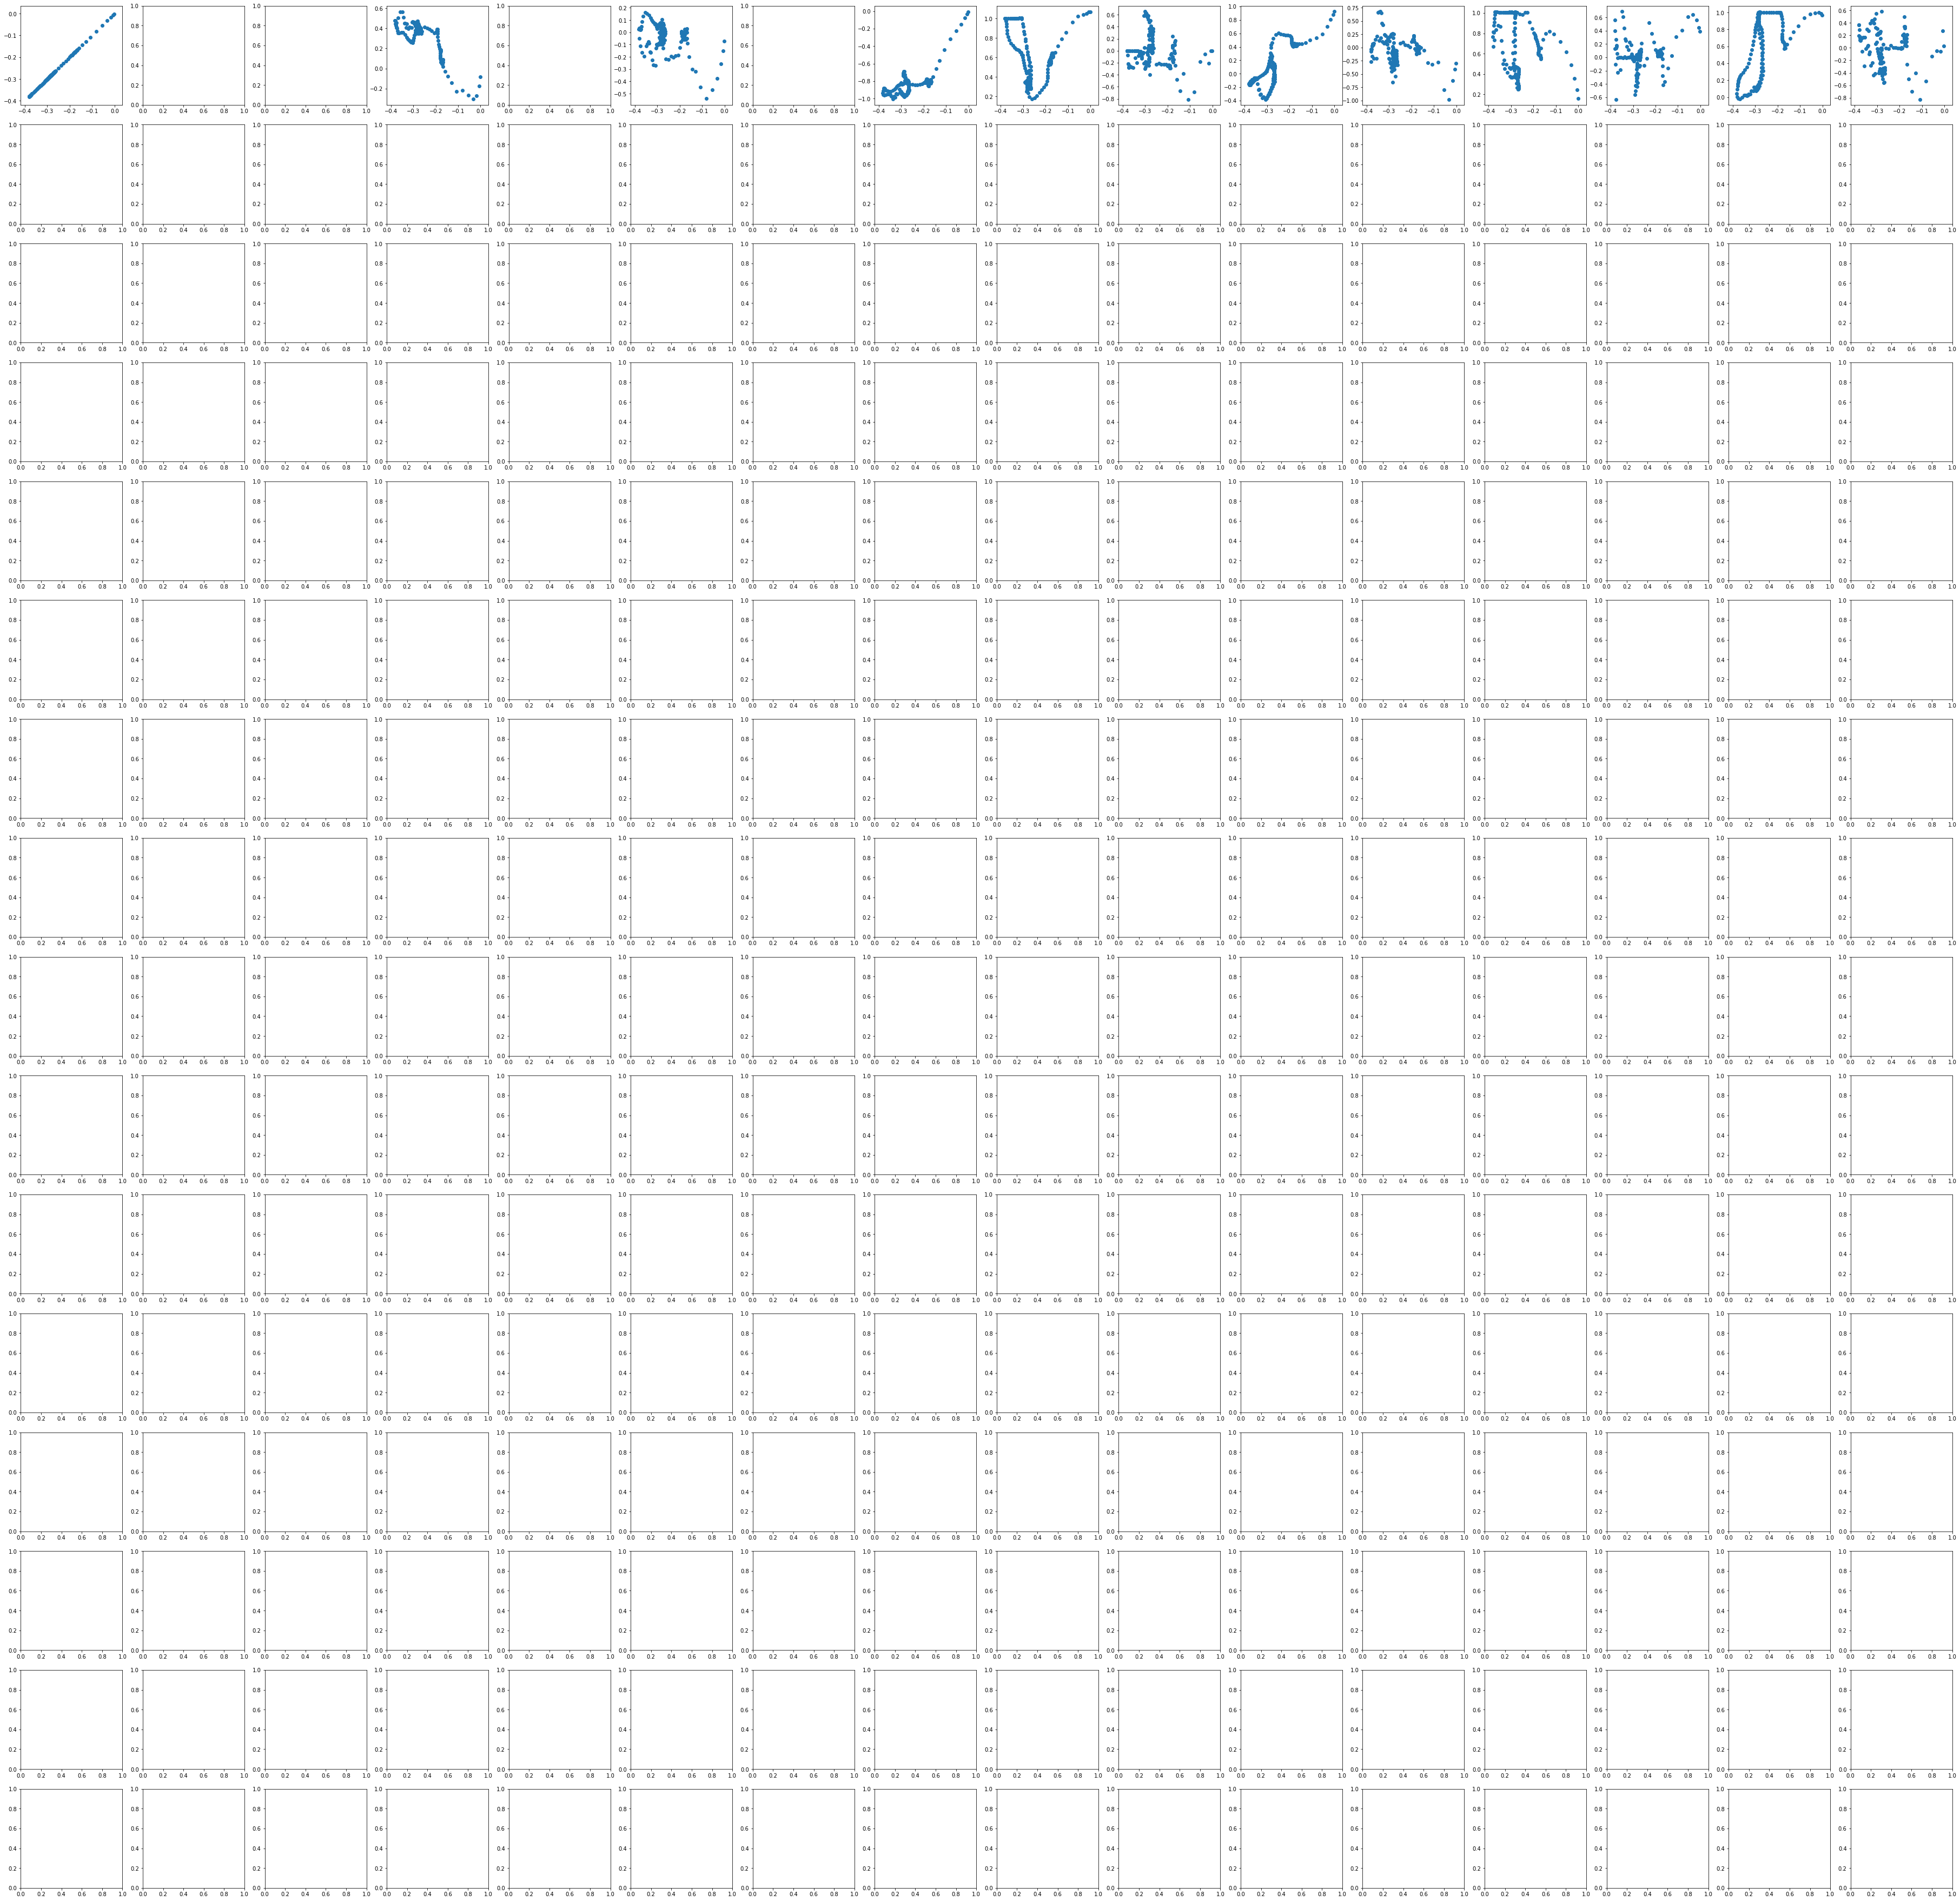

In [57]:
env = gym.make(env_name)
from itertools import product
n_states = env.observation_space.shape[0]

useful_states = [0, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
fig, ax = plt.subplots(len(useful_states), len(useful_states), figsize=(64,64))

for i, j in product(useful_states, useful_states):
    ax[i,j].scatter(mesht[:,i], mesht[:,j])

TypeError: list indices must be integers or slices, not tuple